In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

# Define preprocessing transformation
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.3),
])

# Function to preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = transform(image=img)["image"]
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=0)

# Data Directories
train_dir = "/content/drive/MyDrive/Major_Project/processed_dataset/train"
val_dir = "/content/drive/MyDrive/Major_Project/processed_dataset/val"
test_dir = "/content/drive/MyDrive/Major_Project/processed_dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

def load_dataset(directory):
    return image_dataset_from_directory(
        directory, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
    )

train_dataset = load_dataset(train_dir)
val_dataset = load_dataset(val_dir)
test_dataset = load_dataset(test_dir)

# Compute Class Weights (Fix applied)
y_train = np.concatenate([y.numpy().flatten() for _, y in train_dataset])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}

# EfficientNet Model
base_model = tf.keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = True
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
efficientnet_output = layers.Dense(512, activation="relu")(x)

# U-Net Model
def build_unet(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="U-Net")

unet_model = build_unet()
combined_input = layers.Concatenate()([efficientnet_output, unet_model.output])
final_output = layers.Dense(1, activation="sigmoid")(combined_input)

# Final Model
model = keras.Model(inputs=[base_model.input, unet_model.input], outputs=final_output)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



Found 2800 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# Training Preparation
def preprocess_dataset(dataset):
    images, labels = [], []
    for x, y in dataset:
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)

train_X, train_Y = preprocess_dataset(train_dataset)
val_X, val_Y = preprocess_dataset(val_dataset)

# Training with Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    [train_X, train_X], train_Y,
    epochs=10,
    validation_data=([val_X, val_X], val_Y),
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)



Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.5050 - loss: 0.7686

88/88 ━━━━━━━━━━━━━━━━━━━━ 156s 812ms/step - accuracy: 0.5053 - loss: 0.7681 - val_accuracy: 0.5050 - val_loss: 0.7396
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6491 - loss: 0.6452

88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - accuracy: 0.6492 - loss: 0.6451 - val_accuracy: 0.6125 - val_loss: 0.6621
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7067 - loss: 0.6001

88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.7068 - loss: 0.5999 - val_accuracy: 0.6687 - val_loss: 0.6110
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7503 - loss: 0.5312

88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.7504 - loss: 0.5312 - val_accuracy: 0.7013 - val_loss: 0.5730
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7607 - loss: 0.5071

88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.7608 - loss: 0.5070 - val_accuracy: 0.7188 - val_loss: 0.5517
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8182 - loss: 0.4409

88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.8182 - loss: 0.4409 - val_accuracy: 0.7713 - val_loss: 0.4961
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8240 - loss: 0.4121

88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.8241 - loss: 0.4120 - val_accuracy: 0.7825 - val_loss: 0.4762
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8459 - loss: 0.3771

88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.8458 - loss: 0.3770 - val_accuracy: 0.8025 - val_loss: 0.4382
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8488 - loss: 0.3487

88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.8489 - loss: 0.3486 - val_accuracy: 0.8138 - val_loss: 0.4203
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.8966 - loss: 0.2929 - val_accuracy: 0.8075 - val_loss: 0.4286


In [9]:
# Model Evaluation
test_X, test_Y = preprocess_dataset(test_dataset)
y_pred_probs = model.predict([test_X, test_X])
y_pred = (y_pred_probs > 0.5).astype("int")

print("Classification Report:\n", classification_report(test_Y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_Y, y_pred))

false_positives = np.sum((test_Y == 0) & (y_pred == 1))
false_negatives = np.sum((test_Y == 1) & (y_pred == 0))
print(f"False Positives: {false_positives}, False Negatives: {false_negatives}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.81      0.79       200
         1.0       0.80      0.77      0.78       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

Confusion Matrix:
 [[161  39]
 [ 46 154]]
False Positives: 39, False Negatives: 46


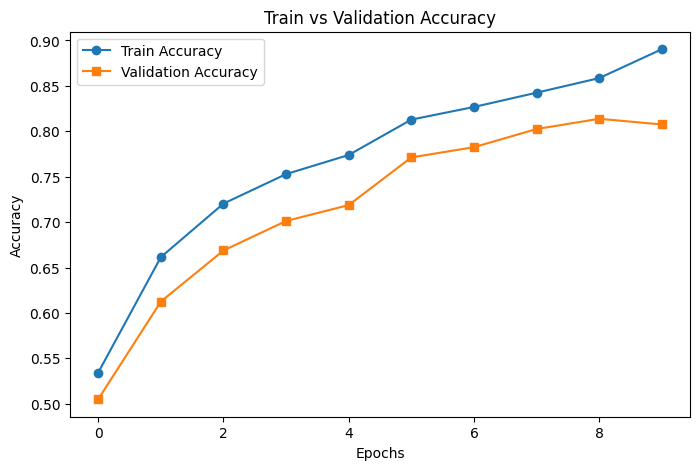

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# ⬇️ Extract Train & Validation Accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# ⬇️ Plot Accuracy Graph
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Validation Accuracy")
plt.show()


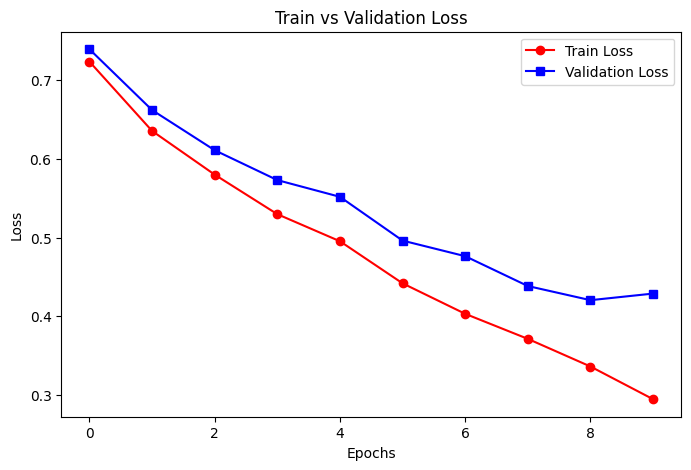

In [74]:
# ⬇️ Extract Train & Validation Loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# ⬇️ Plot Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss', marker='o', color='red')
plt.plot(val_loss, label='Validation Loss', marker='s', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# ⬇️ Extract Train & Validation Accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# ⬇️ Plot Accuracy Graph
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Validation Accuracy")
plt.show()


In [32]:
# Inference
def predict_image(image_path):
    image = preprocess_image(image_path)
    probability = model.predict([image, image])[0, 0]
    print(f"Prediction Probability: {probability:.4f}")
    return "FAKE" if probability > 0.4982 else "REAL"

unseen_image_path = "/content/Alia_Bhatt,_Chennai_(cropped_2).jpg"
prediction = predict_image(unseen_image_path)
print("Predicted Class:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction Probability: 0.4971
Predicted Class: REAL


In [34]:
unseen_image_path = "/content/drive/MyDrive/Major_Project/dataset_part-r/test/fake/easy_123_0100.jpg"
prediction = predict_image(unseen_image_path)
print("Predicted Class:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction Probability: 0.4985
Predicted Class: FAKE


In [35]:
unseen_image_path = "/content/drive/MyDrive/Major_Project/dataset_part-r/test/fake/easy_142_1111.jpg"
prediction = predict_image(unseen_image_path)
print("Predicted Class:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prediction Probability: 0.4985
Predicted Class: FAKE


In [38]:
unseen_image_path = "/content/0068-ajay-devgn.jpg"
prediction = predict_image(unseen_image_path)
print("Predicted Class:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Prediction Probability: 0.4962
Predicted Class: REAL


In [71]:
unseen_image_path = "/content/Fake_image.png"
prediction = predict_image(unseen_image_path)
print("Predicted Class:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction Probability: 0.4972
Predicted Class: REAL


In [67]:
unseen_image_path = "/content/drive/MyDrive/Major_Project/dataset/real/real_00011.jpg"
prediction = predict_image(unseen_image_path)
print("Predicted Class:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction Probability: 0.4966
Predicted Class: REAL
